## Introduction

This notebook serves as a demonstration of how one might use parallel_plugin.ipynb in a realistic data science scenario - ie. where the notebook uses external files, classes, global functions/variables, and automatic differentiation. 

Consider the problem of bayesian linear regression (cf. Bishop 3.3). We will first learn the mean via metropolis hastings and variational inference.

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import optim
import numpy as np
import pandas as pd
from torch.distributions.normal import Normal
import numpy.random as npr
from models import LinRegGuide, Elbo
from helpers import seed_all, linear_regression_data

In [2]:
# Metropolis sampling (symmetric proposal) for given log-target distribution
def mhsample(x0, n, logtarget, drawproposal):
    x = x0
    xs = torch.zeros(x0.shape[0], n)
    accepts = 0
    for i in range(n):
        if (i % 1000) == 0:
            print("Steps: {}".format(i))
        x_prop = drawproposal(x)
        if np.log(npr.rand()) < logtarget(x_prop) - logtarget(x):
            x = x_prop
            accepts += 1
        xs[:, i] = x
    print("Sampler acceptance rate:", accepts/n)
    return xs

In [3]:
offset = 0
N = 1000
D = 2
X, y, w_true = linear_regression_data(N, D, 10)
proposal_std = 0.01

In [4]:
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE
    
def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE

In [5]:
training_epochs = 20000

w_hat, RMSE = run_metropolis_hastings(training_epochs)
print("The true mean is:", w_true.numpy())
print("The mean learned w/ metropolis hastings is:", w_hat)
print("RMSE:", RMSE)

Steps: 0
Steps: 1000
Steps: 2000
Steps: 3000
Steps: 4000
Steps: 5000
Steps: 6000
Steps: 7000
Steps: 8000
Steps: 9000
Steps: 10000
Steps: 11000
Steps: 12000
Steps: 13000
Steps: 14000
Steps: 15000
Steps: 16000
Steps: 17000
Steps: 18000
Steps: 19000
Sampler acceptance rate: 0.78885
The true mean is: [10.715813 11.202667]
The mean learned w/ metropolis hastings is: [10.761485 11.173508]
RMSE: 0.038316112


In [6]:
training_epochs = 200

w_hat, RMSE = run_variational_inference(training_epochs)
print("The true mean is:", w_true.numpy())
print("The mean learned w/ variational inference is:", w_hat)
print("RMSE:", RMSE)

0 160548.25
10 38632.75390625
20 2027.759521484375
30 4855.123046875
40 3597.0439453125
50 1623.9044189453125
60 1583.623779296875
70 1582.6783447265625
80 1559.236572265625
90 1545.2755126953125
100 1531.69677734375
110 1540.6229248046875
120 1529.766357421875
130 1548.21044921875
140 1532.156982421875
150 1532.447021484375
160 1531.6285400390625
170 1536.0352783203125
180 1529.504638671875
190 1531.744140625
The true mean is: [10.715813 11.202667]
The mean learned w/ variational inference is: [10.750791 11.180419]
RMSE: 0.029312454


## Using parallel_plugin.ipydb

Now, let's say we want to plot RMSE as a function of training iterations. This would normally require mapping the above functions across a range of values. Instead lets see how we can use the parallel_mixin to make this easier.

First, we load the plugin using Jupyter's magic command 'run', and initialize by passing in the names of any external files we need.

In [5]:
%run parallel_plugin.ipynb
init_parallel(['models.py', 'helpers.py'])

Starting multiprocess cluster...
Starting multithread cluster...
Parallel Plugin Loaded. You can now decorate functions with @profile(profile_array) and @parallel(map=True, threads=True, background=False). 
get_results(futures) and MyClient have also been loaded into your namespace


Before running the methods in parallel we first profile them to see what kind of speed up we can expect. Normally one would decorate the existing functions, but for demonstration purposes I'll duplicate the functions below.

The @profile argument takes the range of values you expect to pass in to your parallelized function.  

In [7]:
@profile(range(2000, 20000, 2000))
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE
    
@profile(range(1, 100, 10))
def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return w_hat, RMSE

We now call the decorated functions without arguments. This takes a little while because we have to first run the sequential version as a baseline:

In [9]:
run_metropolis_hastings()

---------Parallel vs Sequential Profile--------
Function: run_metropolis_hastings
Input length: 9
Input type: <class 'int'>
Timing...
Sequential time: 38.4361s
Multiprocessing time: 23.3289s (~1.6476x speedup, 4 workers, 2 cores/worker)
Multithreading time: 21.8173s (~1.7617x speedup, 1 workers, 8 cores/worker)


In [15]:
run_variational_inference()

---------Parallel vs Sequential Profile--------
Function: run_variational_inference
Input length: 10
Input type: <class 'int'>
Timing...
Sequential time: 0.3095s
Multiprocessing time: 0.5614s (~0.5513x speedup, 4 workers, 2 cores/worker)
Multithreading time: 0.5548s (~0.5579x speedup, 1 workers, 8 cores/worker)


The profiler returns some useful information. We see we get about a 1.5x speedup by parallelizing run_metropolis_hastings() and the difference between threads and processes is negligible (rerunning the profiler confirms this). 

We also see that parallelizing actually hurts performance with run_variational_inference() due to overhead costs.

With this we decide to parallelize the run_metropolis_hastings() function:

In [6]:
@parallel(map=True, background=False, )
def run_metropolis_hastings(ITERS):
    seed_all(0)
    
    model = LinRegGuide(D)

    target = lambda w: model.mh_target(X, y, w)
    proposal = lambda w: w + proposal_std*torch.randn(D)

    x0 = torch.zeros(D)
    
    xs = mhsample(x0, ITERS, target, proposal)
    
    # Discard the first half of samples as warm-up
    xs = xs[:, xs.shape[1]//2:]
    xs = pd.DataFrame(xs.numpy().T)

    w_hat = xs.mean().values
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return RMSE, ITERS

def run_variational_inference(EPOCHS):
    seed_all(0)
    model = LinRegGuide(D)
    criterion = Elbo(model)
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

    for epoch in range(EPOCHS):
        opt.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            print(epoch, loss.item())
            
    w_hat = model.mu.squeeze().detach().numpy()
    RMSE = np.sqrt(((w_hat - w_true.numpy())**2).mean())
    return RMSE, EPOCHS

By decorating with the map=True flag, the function now accepts a list of values. If we set background=True, the function will run in the background. This is useful if we want to do work in other cells while the job is running. Notice how the functions parallelize in the presence of globally defined variables and functions (something ipyparallel doesn't do)

In [9]:
mh_results = run_metropolis_hastings(range(2000, 20000, 2000))

In [10]:
vi_results = [run_variational_inference(i) for i in range(1, 100, 10)]

0 124769.109375
0 124769.109375
10 34566.34375
0 124769.109375
10 34566.34375
20 3407.84814453125
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
50 1904.282958984375
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
50 1904.282958984375
60 1560.0072021484375
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
50 1904.282958984375
60 1560.0072021484375
70 1560.3155517578125
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
50 1904.282958984375
60 1560.0072021484375
70 1560.3155517578125
80 1608.6796875
0 124769.109375
10 34566.34375
20 3407.84814453125
30 2867.71337890625
40 3334.52685546875
50 1904.282958984375
60 1560.0072021484375
70 1560.3155517578125
80 1608.67

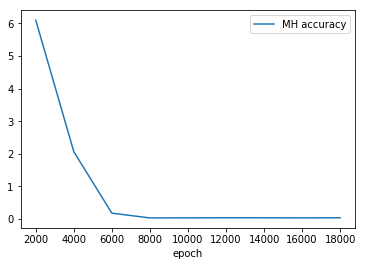

In [11]:
pd.DataFrame(mh_results, columns=['MH accuracy', 'epoch']).set_index('epoch').sort_index().plot()

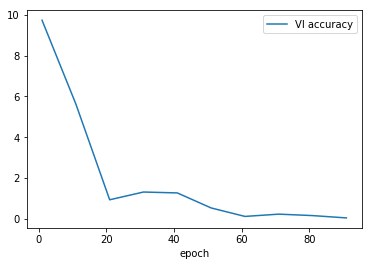

In [12]:
pd.DataFrame(vi_results, columns=['VI accuracy', 'epoch']).set_index('epoch').sort_index().plot()